### Import the necessary libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline

### Load the data into Pandas dataframe

In [10]:
df = pd.read_csv('spam.csv',delimiter=',',encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


### Data Preprocessing

- checking for null values
- Removing the null values

In [32]:
df.shape

(5572, 5)

<AxesSubplot:>

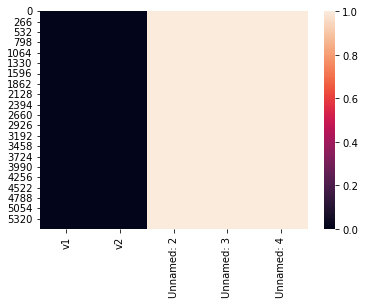

In [12]:
sns.heatmap(df.isnull())

In [11]:
df.isnull().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

### Droping the columns with null values

In [8]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


### Distribution of data

C:\Users\ajaya\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Number of ham and spam messages')

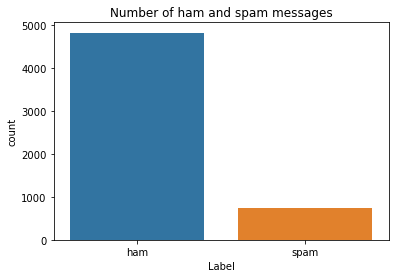

In [14]:
sns.countplot(df['v1'])
plt.xlabel('Label')
plt.title('Number of ham and spam messages')

###  Train and Test split

- Create input and output vectors.
- Process the labels.

In [16]:
X = df.v2
Y = df.v1

#### Encoding the target column

In [18]:
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

In [23]:
Y[:10]

array([[0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1]])

- Split into training and test data

In [24]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)

In [40]:
X_train.sample(5)

1730                          Doing project w frens lor. 
4569    Wanna have a laugh? Try CHIT-CHAT on your mobi...
4291                                                G.W.R
2334                            Do you like Italian food?
3182    Dunno i juz askin cos i got a card got 20% off...
Name: v2, dtype: object

### Process the data

- Tokenize the data and convert the text to sequences.
- Add padding to ensure that all the sequences have the same shape.
- There are many ways of taking the max_len and here an arbitrary length of 150 is chosen.

## Tokenizer

In [25]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

### Building the Model

In [26]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

- built a RNN neural network
- Added LSTM and hidden layers to the neural network

In [27]:
model = RNN()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 150)]             0         
                                                                 
 embedding (Embedding)       (None, 150, 50)           50000     
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257   

### Model compilation

In [28]:
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

### Fit the Model

In [31]:
model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Epoch 1/10
30/30 [==============================] - 4s 133ms/step - loss: 0.0271 - accuracy: 0.9921 - val_loss: 0.0601 - val_accuracy: 0.9873
Epoch 2/10
30/30 [==============================] - 4s 142ms/step - loss: 0.0216 - accuracy: 0.9931 - val_loss: 0.0591 - val_accuracy: 0.9873


### Model Evaluation

In [33]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [34]:
accr = model.evaluate(test_sequences_matrix,Y_test)

27/27 [==============================] - 0s 16ms/step - loss: 0.0317 - accuracy: 0.9892


In [35]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.032
  Accuracy: 0.989


### Model Save

In [37]:
model.save("spamclassification.h5")

### Model Testing

In [49]:
sample_texts = ["Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005"]

txts = tok.texts_to_sequences(sample_texts)
txts = sequence.pad_sequences(txts, maxlen=max_len)
preds = model.predict(txts)
preds

array([[0.9838892]], dtype=float32)